In [1]:
import h5py
import numpy as np
seed = 7
np.random.seed(seed)
import pandas as pd
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, merge
from keras.models import Model

Using TensorFlow backend.


In [ ]:
radius = 'ak5' # Jet radius to use. Either 'ak5' or 'ak7'

In [2]:
####################
# Global Variables #
####################
nx = 25 if radius == 'ak5' else 30 # size of image in eta
ny = 25 if radius == 'ak5' else 30 # size of image in phi
xbins = np.linspace(-1.0,1.0,nx+1)
ybins = np.linspace(-1.0,1.0,ny+1)

In [3]:
input_layer = Input(shape=(nx,ny,1))
layer = Convolution2D(15, (9,9), padding='same')(input_layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(10, (7,7), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Convolution2D(8, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = Convolution2D(6, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(4, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)

layer = Flatten()(layer)

# additional features input
jet_eta_input = Input(shape=(1,), name='jet_eta_input')
layer = merge([layer, jet_eta_input], mode='concat')
layer = Dense(20, activation='sigmoid')(layer)
layer = Dropout(0.08)(layer)
jet_pt_input = Input(shape=(1,), name='jet_pt_input')
layer = merge([layer, jet_pt_input], mode='concat')
layer = Dense(20, activation='softplus')(layer)
layer = Dropout(0.08)(layer)
output_layer = Dense(1, activation='linear', name='main_output')(layer)
model = Model(inputs=[input_layer,jet_pt_input,jet_eta_input], outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy','mse','msle'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 25, 15)   1230        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 25, 25, 15)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 15)   0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [4]:
df_jets = pd.read_pickle('data/{}/df_jets_.pkl'.format(radius, radius))

In [5]:
from sklearn.model_selection import train_test_split
df_jets_train, df_jets_test = train_test_split(df_jets, train_size=0.8, random_state = seed)

jet_images_train = np.stack(df_jets_train['jet_images'])
jet_images_test = np.stack(df_jets_test['jet_images'])

In [6]:
print(df_jets_train.shape)
print(df_jets_test.shape)

print(jet_images_train.shape)
print(jet_images_test.shape)

(42393, 33)
(10599, 33)
(42393, 25, 25, 1)
(10599, 25, 25, 1)


In [7]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
bs=256

In [8]:
history = model.fit([jet_images_train, df_jets_train['jet_pt'], df_jets_train['jet_eta']],  df_jets_train['jet_jes'],
                    validation_data=([jet_images_test, df_jets_test['jet_pt'], df_jets_test['jet_eta']], df_jets_test['jet_jes']),
                    nb_epoch=400, batch_size=bs, verbose=1, callbacks=[early_stopping])

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 42393 samples, validate on 10599 samples
Epoch 1/400
42393/42393 [==============================] - 4s 98us/step - loss: 0.1147 - acc: 0.0000e+00 - mean_squared_error: 0.1147 - mean_squared_logarithmic_error: 0.0369 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0014 - val_mean_squared_logarithmic_error: 3.4579e-04
Epoch 2/400
42393/42393 [==============================] - 3s 74us/step - loss: 0.0455 - acc: 0.0000e+00 - mean_squared_error: 0.0455 - mean_squared_logarithmic_error: 0.0127 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0011 - val_mean_squared_logarithmic_error: 2.6374e-04
Epoch 3/400
42393/42393 [==============================] - 3s 73us/step - loss: 0.0318 - acc: 0.0000e+00 - mean_squared_error: 0.0318 - mean_squared_logarithmic_error: 0.0086 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0011 - val_mean_squared_logarithmic_error: 2.6496e-04
Epoch 4/400
42393/42393 [==============================]

Epoch 28/400
42393/42393 [==============================] - 3s 73us/step - loss: 0.0019 - acc: 0.0000e+00 - mean_squared_error: 0.0019 - mean_squared_logarithmic_error: 4.7999e-04 - val_loss: 9.3959e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 9.3959e-04 - val_mean_squared_logarithmic_error: 2.3457e-04
Epoch 29/400
42393/42393 [==============================] - 3s 73us/step - loss: 0.0017 - acc: 0.0000e+00 - mean_squared_error: 0.0017 - mean_squared_logarithmic_error: 4.3598e-04 - val_loss: 9.3980e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 9.3980e-04 - val_mean_squared_logarithmic_error: 2.3462e-04
Epoch 30/400
42393/42393 [==============================] - 3s 73us/step - loss: 0.0016 - acc: 0.0000e+00 - mean_squared_error: 0.0016 - mean_squared_logarithmic_error: 4.0502e-04 - val_loss: 9.4745e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 9.4745e-04 - val_mean_squared_logarithmic_error: 2.3627e-04
Epoch 31/400
42393/42393 [==============================] - 3s 74us

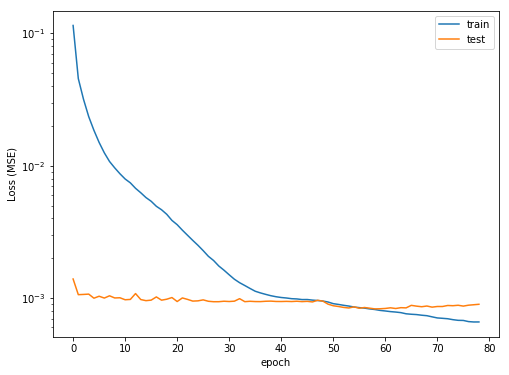

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))

loss = np.asarray(history.history['loss'])
val_loss = np.asarray(history.history['val_loss'])
plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')

plt.savefig('plots/{}/train_val_loss_{}.pdf'.format(radius, radius))

In [10]:
model.save('models/{}/DeepJEC_{}.h5'.format(radius, radius))
df_jets_train.to_pickle('data/{}/df_jets_train_{}.pkl'.format(radius, radius))
df_jets_test.to_pickle('data/{}/df_jets_test_{}.pkl'.format(radius, radius))